# Tree Model Interpretation using SHAP

There are many techniques, each with advantages and disadvantages that can be suitable for different situations. [SHAP](https://shap.readthedocs.io/en/latest/) (SHapley Additive exPlanations) is a game theoretic approach to explain the output of any machine learning model, and is well-suited for exploring feature importances.

Pros:

- Mathematical theory behind explanation of the model.
- Very wide application and ease of use. Explanations on single sample and global level, and a number of graphs that can be very easily computed and understood.
- Feature interactions taken into account by the method.
- High computation speed, especially for the TreeExplainer

Cons:

- Documentation is often lacking.
- Different API when you use sklearn models e.g. RandomForestClassifier.
- Slow computation for some explainers e.g. KernelExplainer.

Let's assume we want to analyse the following model:

In [15]:
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from probatus.interpret import ShapModelInterpreter
import warnings
warnings.filterwarnings('ignore')

feature_names = ['f1', 'f2', 'f3', 'f4']
 
# Prepare two samples
X, y = make_classification(n_samples=1000, n_features=4, random_state=0)
X = pd.DataFrame(X, columns=feature_names)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Prepare and fit model. Remember about class_weight="balanced" or an equivalent.
clf = RandomForestClassifier(n_estimators = 100, max_depth=2, random_state=0)
clf = clf.fit(X_train, y_train)

## ShapModelInterpreter

The `ShapModelInterpreter` class in Probatus, is a convenience wrapper class that allows to easily interpret the ML models. Currently it supports only **tree-based models**.

### Feature importance
Firstly, lets compute the report presenting various properties of the model:

- `mean_abs_shap_value_test` - SHAP feature importance computed on the test set. It is an unbiased measurement of feature importance of the model on unseen data.
- `mean_abs_shap_value_train` - SHAP feature importance computed on the test set. It is a biased measurement, because the model has used this data to train. However, the a significant difference between this metric, and the `mean_abs_shap_value_test` might indicate a shift in the data distribution, target distribution, or overfitting of the model.
- `mean_shap_value_test` - This metric presents how strongly values of a given feature in the test set, push the prediction towards one class or the other. The positive value, indicates that this feature increases probability of positive class, and negative indicates that it decreases it. In the balanced setting it is typically around 0, and imbalanced it has is relative to the majority class. It is crucial to compare it with `mean_shap_value_train`, if it differs significantly, there is possibly a shift in data or target distribution in the test set.
- `mean_shap_value_train` - This metric presents how strongly values of a given feature in the train set, similarly to `mean_shap_value_test`.


In [16]:
shap_interpreter = ShapModelInterpreter(clf)
feature_importance = shap_interpreter.fit_compute(X_train, X_test, y_train, y_test, approximate=False)
feature_importance

,mean_abs_shap_value_test,mean_abs_shap_value_train,mean_shap_value_test,mean_shap_value_train
f1,0.287474,0.287337,0.018180,0.004949
f4,0.119999,0.122428,-0.008028,-0.004856
f3,0.049786,0.045652,-0.005424,-0.002996
f2,0.006036,0.006649,0.002185,0.003030


Run the following command to plot the SHAP feature importance.

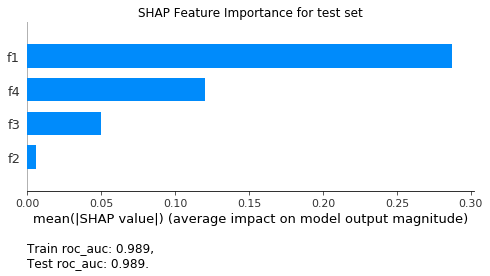

In [17]:
ax = shap_interpreter.plot('importance')

The AUC on train and test sets is illustrated in each plot, to indicate if the model overfits. If you see that Test AUC is significantly lower than Train AUC, this is a sign that the model might be overfitting. In such case, the interpretation of the model might be misleading. In such situations we recommend retraining the model with more regularization.

### Summary plot

Summary plot gives you more insights into how different feature values affect predictions made. This is a very crucial plot to make for every model. Each dot on the X-axis represents a sample in the data, and strongly it affected the prediction (together with predictions direction). The colours of the dots, present the values of that feature. For each model try to analyse this plot with Subject Matter Expert, in order to make sure that the relations that the model has learned make sense.

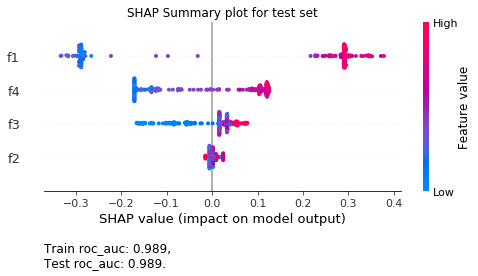

In [18]:
ax = shap_interpreter.plot('summary')


### Dependence Plot

This plot allows you to understand how the model reacts for different feature values. You can plot it for each feature in your model, or at least the top 10 features. This can provide you with further insights on how the model uses each of the features. Moreover, one can detect anomalies, as well as the effect of the outliers on the model. 

As an addition, the bottom plot, presents the feature distribution histogram, and the target rate for different buckets within that feature values. This allows to further analyse how the feature correlates with the target variable.

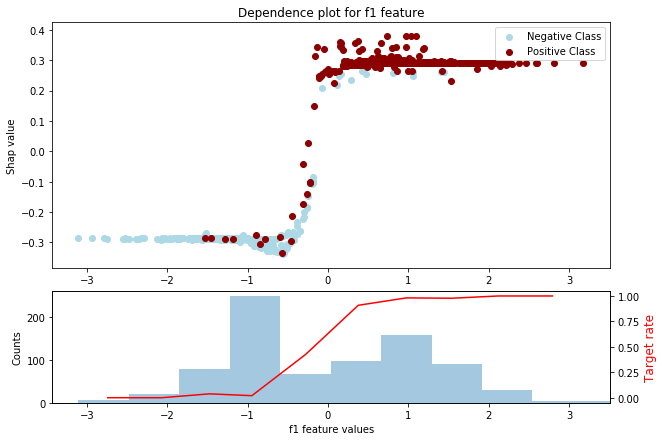

In [19]:
ax = shap_interpreter.plot('dependence', target_columns=['f1'])

### Sample explanation

In order to explain predictions for specific samples from your test set, you can use sample plot. For a given sample, the plot presents the force and direction of prediction shift that each feature value causes.

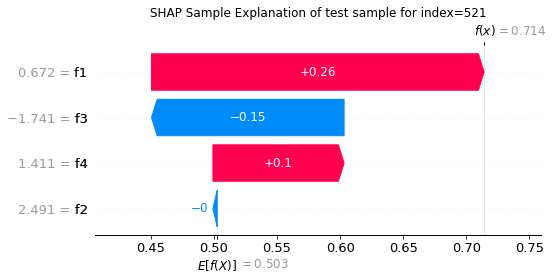

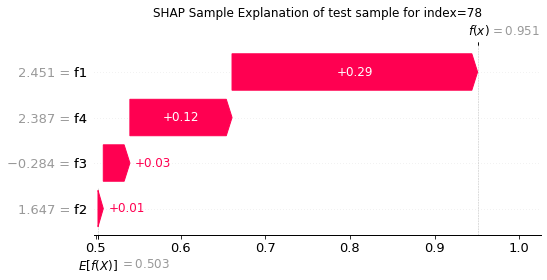

In [20]:
ax = shap_interpreter.plot('sample', samples_index=[521, 78])


## Detecting Data or Target Distribution Shift

Let's assume that there is a shift between train and test data:

In [7]:
X_test['f1'] = X_test['f1'] -5
X_test['f4'] = X_test['f4'] + 5

Now, we can look into how it affects the resutls:

In [8]:
shap_interpreter = ShapModelInterpreter(clf)
feature_importance = shap_interpreter.fit_compute(X_train, X_test, y_train, y_test, approximate=False)
feature_importance

,mean_abs_shap_value_test,mean_abs_shap_value_train,mean_shap_value_test,mean_shap_value_train
f1,0.343097,0.287337,-0.343097,0.004949
f4,0.134433,0.122428,0.134433,-0.004856
f3,0.051540,0.045652,-0.002675,-0.002996
f2,0.006783,0.006649,0.005936,0.003030


In case of feature `f1` and `f4` the shift is indicated by the differences between train and test in mean absolute shap values, and mean shap values.

We can visualize the summary plot for these two sets:

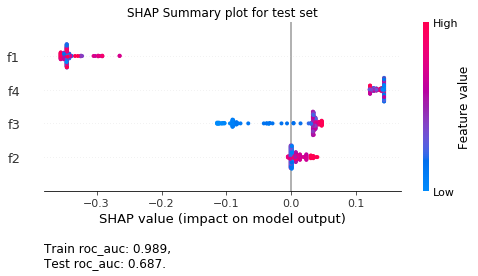

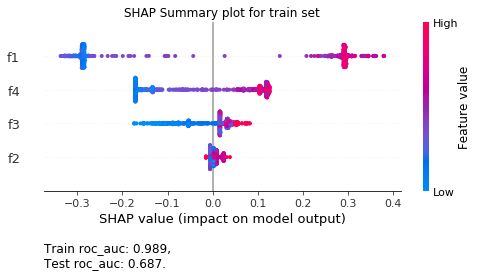

In [10]:
ax_test = shap_interpreter.plot('summary', target_set='test')
ax_train = shap_interpreter.plot('summary', target_set='train')


## Tips for using the interpreter

Before using the ShapModelInterpreter consider the following tips:

- Make sure you do not underfit or overfit the model. Underfitting will cause only the most important relations in the data to be visible, while overfitting will present relationships that do not generalize.
- Perform feature selection process before fitting the final model. This way, many it will be easier to interpret the explanation. Moreover, highly-correlated features will affect the explanation less.
- Preferably use model that handles NaNs e.g. LightGBM or impute them before using SHAP. When imputing also extract a MissingIndicator to get insights into when NaNs are meaningful for the model.
- For categorical features either use a model that handles them e.g. LightGBM, or apply one-hot encoding. Keep in mind that with One-hot encoding the importance of categorical feature might be spread over multiple encoded features.